# **Problema 3 - Aprendizaje Automático II**
# *Integrantes*:
* ### Demarré, Lucas
* ### Donnarumma, César
* ### Longo, Bruno

---

# **Tabla de contenidos**

1.   [**Librerías**](#)
2.   [**Descargamos y descomprimimos el Dataset**](#)
3.   [**Establecemos la GPU por defecto en caso de estar disponible**](#)
4.   [**Cargamos los Datasets**](#)
5.   [**Visualizamos algunas imágenes**](#)
6.   [**Información de los Datasets**](#)
        1.   [*Clases*](#)
        2.   [*Dataset de entrenamiento*](#)
        3.   [*Dataset de validación*](#)
        4.   [*Dataset de prueba*](#)
        5.   [*Observaciones*](#)
7.   [**Redes Neuronales Densas**](#)
        1.   [*Prueba 1*](#)
        2.   [*Prueba 2*](#)
        3.   [*Prueba 3*](#)
        4.   [*Observaciones*](#)
8.   [**Modelos con capas densas y convolucionales**](#)
        1.   [*Prueba 1*](#)
        2.   [*Prueba 2*](#)
        3.   [*Prueba 3*](#)
        4.   [*Observaciones*](#)
9.   [**Modelos con bloques residuales identidad**](#)
        1.   [*Prueba 1*](#)
        2.   [*Prueba 2*](#)
        3.   [*Observaciones*](#)
10.   [**Modelo que usa como backbone una arquitectura de TensorFlow**](#)
        1.   [*Cargamos nuevamente las imágenes sin reescalado*](#)
        2.   [*EfficientNet*](#)
        3.   [*ResNet50*](#)
        4.   [*Observaciones*](#)

## 1. **Librerías**

In [1]:
import time
import gdown
import optuna
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Rescaling, Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Add

A:\Anaconda\envs\AAII\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. **Descargamos y descomprimimos el Dataset**

In [2]:
# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref: zip_ref.extractall('./TP1-3')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=93dea251-11e6-4e0e-b151-1d08cc7fc72c
To: D:\Cosas de la escuela\Técnicatura en Inteligencia Artificial\Aprendizaje Automático II\Github\Problema 3\TP1-3-natural-scenes.zip
100%|███████████████████████████████████████████████████████████████████████████████| 363M/363M [00:33<00:00, 10.9MB/s]


## 3. **Establecemos la GPU por defecto en caso de estar disponible**

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## 4. **Cargamos los Datasets**

In [7]:
# Definimos las rutas a los datasets
train_dir = 'TP1-3/seg_train/seg_train'
test_dir = 'TP1-3/seg_test/seg_test'

# Definimos el tamaño de lote y las dimensiones de las imágenes
batch_size = 64
img_height = 64
img_width = 64

# Utilizamos 'ImageDataGenerator' para cargar las imágenes
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # Agregamos 'validation_split=0.2' para separar el 20% de los datos para validación
test_datagen = ImageDataGenerator(rescale=1./255)

# Cargamos las imágenes de entrenamiento, validación, prueba y predicción
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## 5. **Visualizamos algunas imágenes**

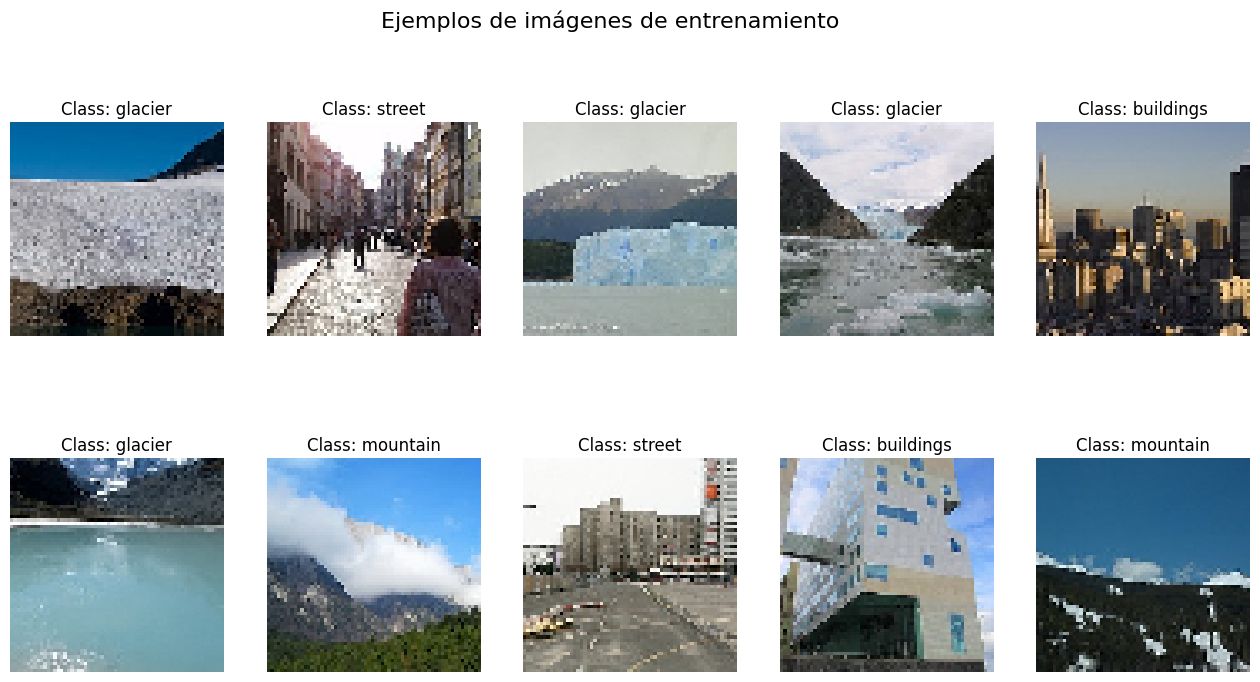

In [8]:
# Obtenemos el diccionario de mapeo de clases
class_mapping = train_data.class_indices

# Invertimos el diccionario para obtener un mapeo de nombres de clases a números
class_mapping = {v: k for k, v in class_mapping.items()}

# Función para visualizar las imágenes
def visualizar_ejemplos(dataset, nombre_dataset):
    # Obtenemos un lote de imágenes y etiquetas
    imagenes, etiquetas = dataset.next()

    # Definimos el tamaño de la cuadrícula para visualización
    num_filas, num_columnas = 2, 5
    num_imagenes = num_filas * num_columnas

    # Creamos una figura para visualizar las imágenes
    plt.figure(figsize=(16, 8))
    plt.suptitle('Ejemplos de imágenes de ' + nombre_dataset, fontsize=16)

    # Visualizamos las imágenes
    for i in range(num_imagenes):
        plt.subplot(num_filas, num_columnas, i + 1)
        plt.imshow(imagenes[i])
        clase_num = etiquetas[i].argmax()
        plt.title('Class: ' + class_mapping[clase_num])
        plt.axis('off')
    plt.show()

# Visualizar ejemplos del conjunto de entrenamiento
visualizar_ejemplos(train_data, 'entrenamiento')

## 6. **Información de los Datasets**

### 6.1. *Clases*

In [9]:
print('Clases:\n')
for key, value in class_mapping.items():
    print(f"{key}: {value}")

Clases:

0: buildings
1: forest
2: glacier
3: mountain
4: sea
5: street


### 6.2. Dataset de entrenamiento

In [10]:
valores_unicos, conteos = np.unique(train_data.classes, return_counts=True)

dataset_train = pd.DataFrame()
dataset_train['clase'] = valores_unicos
dataset_train['frec_abs'] = conteos
dataset_train['frec_rel'] = round((dataset_train['frec_abs'] * 100) / dataset_train['frec_abs'].sum(), 2)

print(f'Longitud del dataset de Train: {dataset_train["frec_abs"].sum()}\n')

print('Cantidad de valores unicos por clase:\n')
print(dataset_train.sort_values(by='frec_abs').reset_index(drop=True))

Longitud del dataset de Train: 11230

Cantidad de valores unicos por clase:

   clase  frec_abs  frec_rel
0      0      1753     15.61
1      1      1817     16.18
2      4      1820     16.21
3      5      1906     16.97
4      2      1924     17.13
5      3      2010     17.90


### 6.3. Dataset de validación

In [11]:
valores_unicos, conteos = np.unique(val_data.classes, return_counts=True)

dataset_train = pd.DataFrame()
dataset_train['clase'] = valores_unicos
dataset_train['frec_abs'] = conteos
dataset_train['frec_rel'] = round((dataset_train['frec_abs'] * 100) / dataset_train['frec_abs'].sum(), 2)

print(f'Longitud del dataset de Train: {dataset_train["frec_abs"].sum()}\n')

print('Cantidad de valores unicos por clase:\n')
print(dataset_train.sort_values(by='frec_abs').reset_index(drop=True))

Longitud del dataset de Train: 2804

Cantidad de valores unicos por clase:

   clase  frec_abs  frec_rel
0      0       438     15.62
1      1       454     16.19
2      4       454     16.19
3      5       476     16.98
4      2       480     17.12
5      3       502     17.90


### 6.4. Dataset de prueba

In [12]:
valores_unicos, conteos = np.unique(test_data.classes, return_counts=True)

dataset_train = pd.DataFrame()
dataset_train['clase'] = valores_unicos
dataset_train['frec_abs'] = conteos
dataset_train['frec_rel'] = round((dataset_train['frec_abs'] * 100) / dataset_train['frec_abs'].sum(), 2)

print(f'Longitud del dataset de Train: {dataset_train["frec_abs"].sum()}\n')

print('Cantidad de valores unicos por clase:\n')
print(dataset_train.sort_values(by='frec_abs').reset_index(drop=True))

Longitud del dataset de Train: 3000

Cantidad de valores unicos por clase:

   clase  frec_abs  frec_rel
0      0       437     14.57
1      1       474     15.80
2      5       501     16.70
3      4       510     17.00
4      3       525     17.50
5      2       553     18.43


### 6.5. **Observaciones**

Parece ser que el Dataset de entrenamiento esta ligeramente desbalanceado

## 7. **Modelos con únicamente capas densas**

### 7.1. *Prueba 1*

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dropout (Dropout)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 793)               9745177   
                                                                 
 dropout_1 (Dropout)         (None, 793)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 4764      
                                                                 
Total params: 9749941 (37.19 MB)
Trainable params: 9749941 (37.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
176/

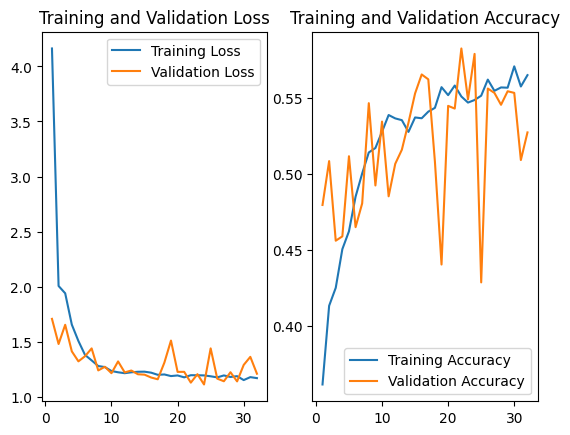


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.984233  0.612289
Test   1.251590  0.517333
---------------------------------------------------------

47/47 [==============================] - 2s 43ms/step


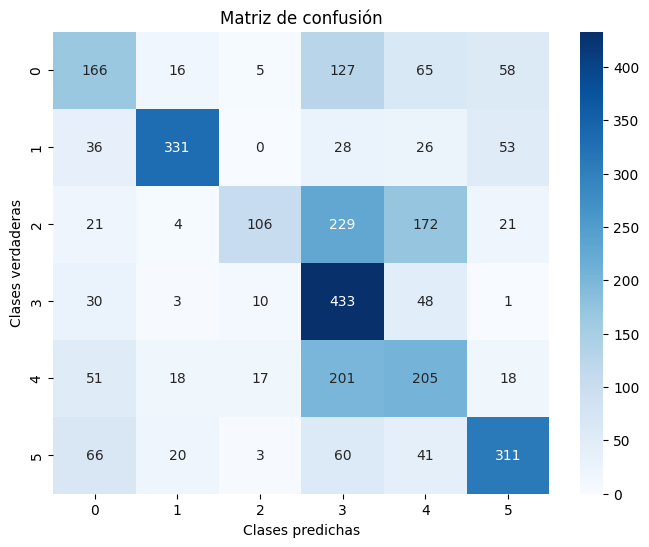


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.45      0.38      0.41       437
           1       0.84      0.70      0.76       474
           2       0.75      0.19      0.31       553
           3       0.40      0.82      0.54       525
           4       0.37      0.40      0.38       510
           5       0.67      0.62      0.65       501

    accuracy                           0.52      3000
   macro avg       0.58      0.52      0.51      3000
weighted avg       0.58      0.52      0.50      3000

Tiempo de ejecución: 470.34 segundos


In [13]:
# Empezamos calculando el tiempo de ejcución
start_time = time.time()

# Modelo
model = Sequential()
model.add(Flatten(input_shape=(img_height, img_width, 3)))
model.add(Dropout(0.591121618030709))
model.add(Dense(units=793, activation='leaky_relu'))
model.add(Dropout(0.28907592045886715))
model.add(Dense(units=6, activation='softmax'))
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

# Calculamos y mostramos el tiempo total de ejecución
end_time = time.time()
total_time_test1 = end_time - start_time
print(f'Tiempo de ejecución: {total_time_test1:.2f} segundos')

### 7.2. *Prueba 2*

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1572992   
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1585798 (6.05 MB)
Trainable params: 1585798 (6.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
176/

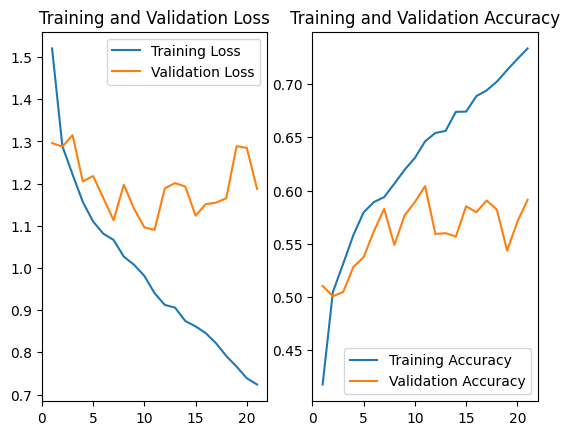


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.651826  0.761621
Test   1.190897  0.593000
---------------------------------------------------------

47/47 [==============================] - 2s 44ms/step


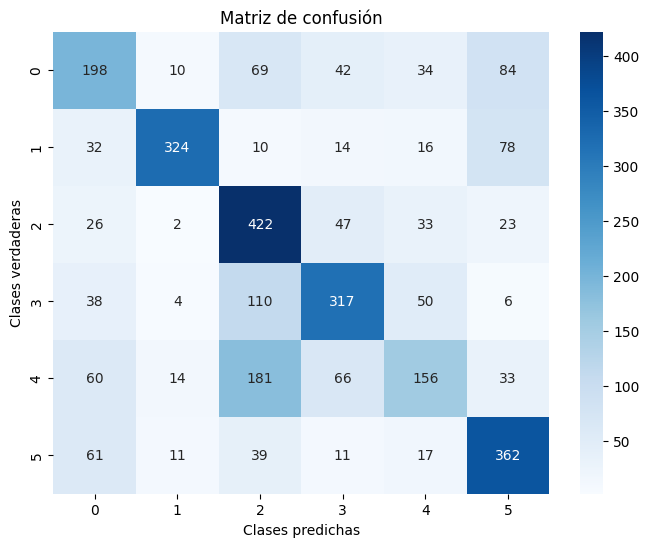


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.48      0.45      0.46       437
           1       0.89      0.68      0.77       474
           2       0.51      0.76      0.61       553
           3       0.64      0.60      0.62       525
           4       0.51      0.31      0.38       510
           5       0.62      0.72      0.67       501

    accuracy                           0.59      3000
   macro avg       0.61      0.59      0.59      3000
weighted avg       0.60      0.59      0.59      3000

Tiempo de ejecución: 282.90 segundos


In [14]:
# Empezamos calculando el tiempo de ejcución
start_time = time.time()

# Modelo
model = Sequential()
model.add(Flatten(input_shape=(img_height, img_width, 3)))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=6, activation='softmax'))
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compila el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

# Calculamos y mostramos el tiempo total de ejecución
end_time = time.time()
total_time_test2 = end_time - start_time
print(f'Tiempo de ejecución: {total_time_test2:.2f} segundos')

### 7.3. *Prueba 3*

Epoch 1/200
176/176 [==============================] - 16s 71ms/step - loss: 1.7881 - accuracy: 0.3897 - val_loss: 1.3909 - val_accuracy: 0.4747 - lr: 0.0010
Epoch 2/200
176/176 [==============================] - 10s 59ms/step - loss: 1.3368 - accuracy: 0.4900 - val_loss: 1.3041 - val_accuracy: 0.4979 - lr: 0.0010
Epoch 3/200
176/176 [==============================] - 11s 60ms/step - loss: 1.2543 - accuracy: 0.5272 - val_loss: 1.2839 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 4/200
176/176 [==============================] - 10s 57ms/step - loss: 1.2068 - accuracy: 0.5451 - val_loss: 1.2105 - val_accuracy: 0.5446 - lr: 0.0010
Epoch 5/200
176/176 [==============================] - 11s 60ms/step - loss: 1.1712 - accuracy: 0.5539 - val_loss: 1.1934 - val_accuracy: 0.5464 - lr: 0.0010
Epoch 6/200
176/176 [==============================] - 11s 61ms/step - loss: 1.1179 - accuracy: 0.5793 - val_loss: 1.2186 - val_accuracy: 0.5321 - lr: 0.0010
Epoch 7/200
176/176 [==============================]

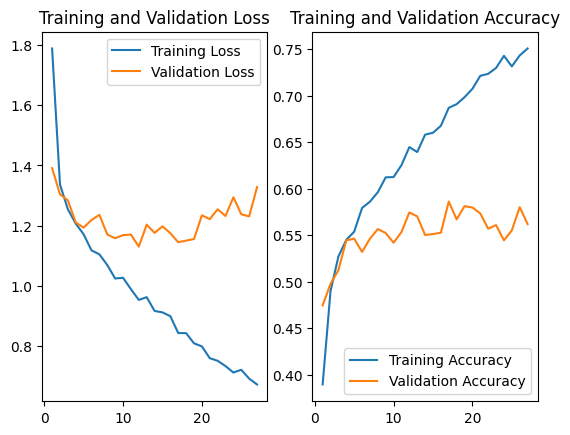


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.697220  0.742386
Test   1.391508  0.545333
---------------------------------------------------------

47/47 [==============================] - 2s 43ms/step


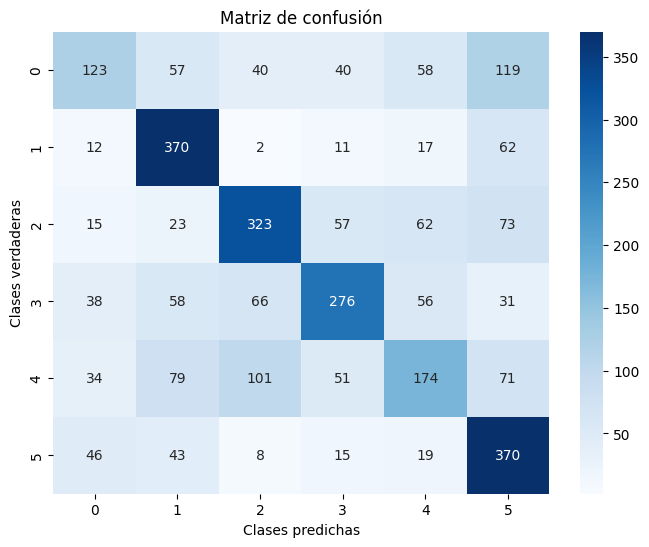


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.46      0.28      0.35       437
           1       0.59      0.78      0.67       474
           2       0.60      0.58      0.59       553
           3       0.61      0.53      0.57       525
           4       0.45      0.34      0.39       510
           5       0.51      0.74      0.60       501

    accuracy                           0.55      3000
   macro avg       0.54      0.54      0.53      3000
weighted avg       0.54      0.55      0.53      3000

Tiempo de ejecución: 377.52 segundos


In [17]:
# Empezamos calculando el tiempo de ejcución
start_time = time.time()

# Definimos el modelo con capas densas únicamente
model = Sequential([
    Flatten(input_shape=(img_height, img_width, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

# Compilamos el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

# Calculamos y mostramos el tiempo total de ejecución
end_time = time.time()
total_time_test3 = end_time - start_time
print(f'Tiempo de ejecución: {total_time_test3:.2f} segundos')

### 7.4. *Observaciones*

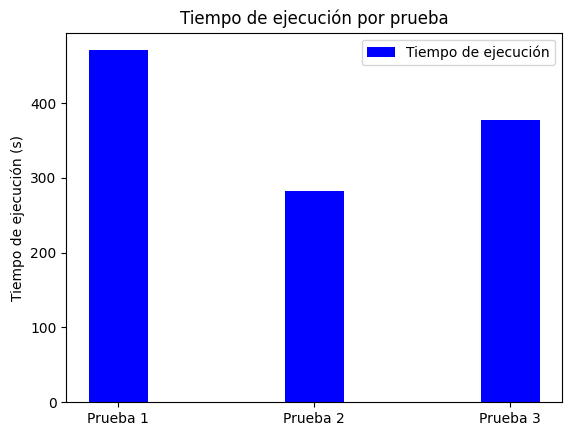

In [18]:
# Tiempo de ejecución de cada prueba
time_test1, time_test2, time_test3 = round(total_time_test1, 2), round(total_time_test2, 2), round(total_time_test3, 2)
tiempo = [time_test1, time_test2, time_test3]

# Etiquetas para las pruebas
labels = ['Prueba 1', 'Prueba 2', 'Prueba 3']

x = np.arange(len(labels))
width = 0.3

# Gráfico de barras
fig, ax = plt.subplots()

# Barras para el tiempo de ejecución
ax.bar(x, tiempo, width, label='Tiempo de ejecución', color='b')

# Etiquetas, título y leyenda
ax.set_ylabel('Tiempo de ejecución (s)')
ax.set_title('Tiempo de ejecución por prueba')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

En estas tres pruebas, observamos que las métricas son poco favorables en general.

La **Prueba 1** registró la métrica más alta debido a su mayor complejidad. Como es nuestra práctica habitual, realizamos pruebas con diferentes niveles de complejidad para comparar sus diferencias.

Sin embargo, en este caso, dada la prolongada duración de ejecución de todas las pruebas y la insatisfactoria calidad de sus métricas, llegamos a la conclusión de que para clasificar estas imágenes, es necesario emplear modelos más complejos que al menos incluyan capas convolucionales.

## 8. **Modelos con capas densas y convolucionales**

### 8.1. *Prueba 1*

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_translation (Random  (None, 64, 64, 3)         0         
 Translation)                                                    
                                                                 
 random_contrast (RandomCon  (None, 64, 64, 3)         0         
 trast)                                                          
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 16)        448   

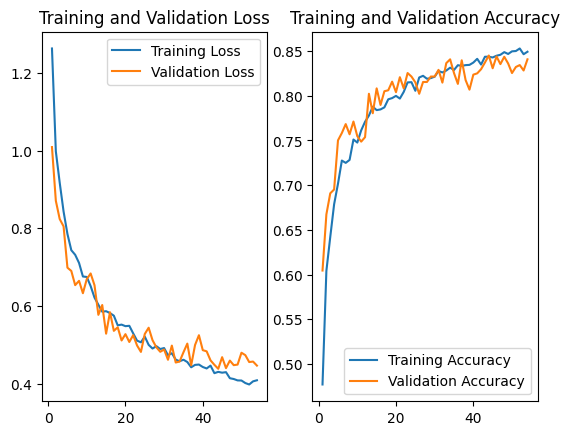


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.339889  0.877293
Test   0.468700  0.836000
---------------------------------------------------------

47/47 [==============================] - 2s 43ms/step


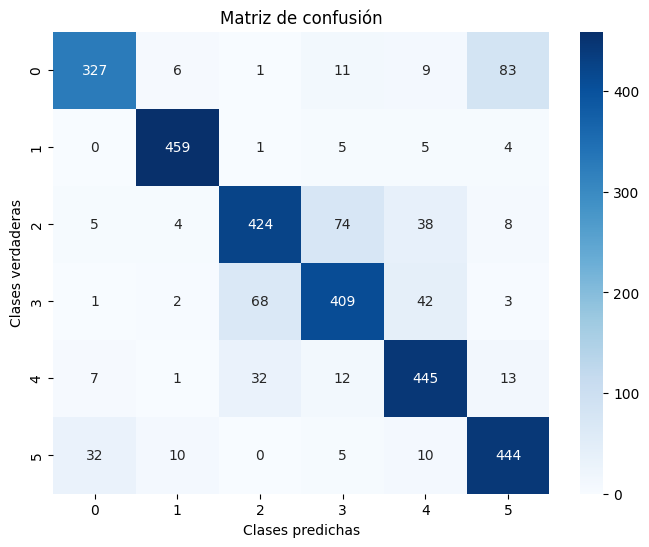


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       437
           1       0.95      0.97      0.96       474
           2       0.81      0.77      0.79       553
           3       0.79      0.78      0.79       525
           4       0.81      0.87      0.84       510
           5       0.80      0.89      0.84       501

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000

Tiempo de ejecución: 889.70 segundos


In [19]:
# Empezamos calculando el tiempo de ejcución
start_time = time.time()

def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    # Data Augmentation
    x = RandomFlip("horizontal")(i)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    # Capas convolucionales
    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    # Capa de salida
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)

    return tf.keras.Model(inputs=[i], outputs=[x])

# Modelo
model = build_model((img_height, img_width, 3), 6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

# Calculamos y mostramos el tiempo total de ejecución
end_time = time.time()
total_time_test1 = end_time - start_time
print(f'Tiempo de ejecución: {total_time_test1:.2f} segundos')

### 8.2. *Prueba 2*

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_translation_1 (Rand  (None, 64, 64, 3)         0         
 omTranslation)                                                  
                                                                 
 random_contrast_1 (RandomC  (None, 64, 64, 3)         0         
 ontrast)                                                        
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 8)         224 

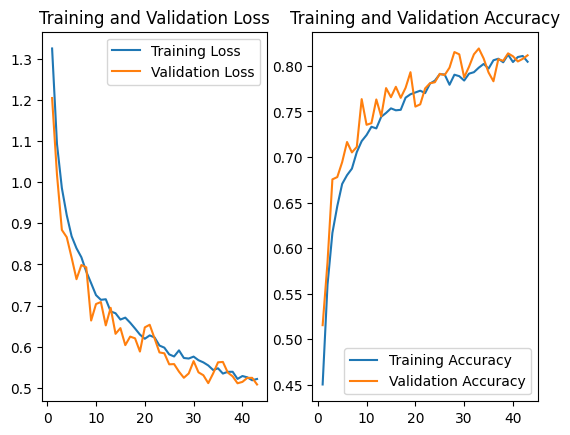


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.456887  0.832502
Test   0.517752  0.812000
---------------------------------------------------------

47/47 [==============================] - 2s 42ms/step


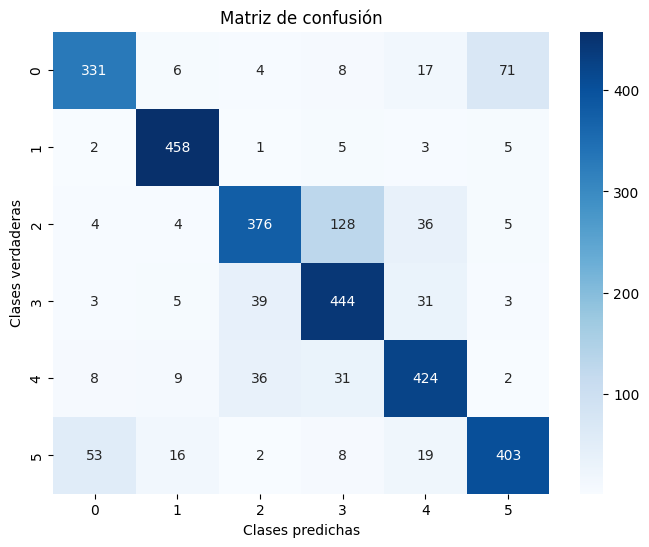


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       437
           1       0.92      0.97      0.94       474
           2       0.82      0.68      0.74       553
           3       0.71      0.85      0.77       525
           4       0.80      0.83      0.82       510
           5       0.82      0.80      0.81       501

    accuracy                           0.81      3000
   macro avg       0.82      0.81      0.81      3000
weighted avg       0.82      0.81      0.81      3000

Tiempo de ejecución: 678.02 segundos


In [22]:
# Empezamos calculando el tiempo de ejcución
start_time = time.time()

# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = RandomFlip('horizontal')(i)
    x = RandomFlip('vertical')(x)
    x = RandomTranslation(0.1, 0.1, fill_mode='reflect')(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation('relu')(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation('softmax')(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

# Modelo
model = build_model((img_height, img_width, 3), 6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

# Calculamos y mostramos el tiempo total de ejecución
end_time = time.time()
total_time_test2 = end_time - start_time
print(f'Tiempo de ejecución: {total_time_test2:.2f} segundos')

### 8.3. *Prueba 3*

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 128)       7385

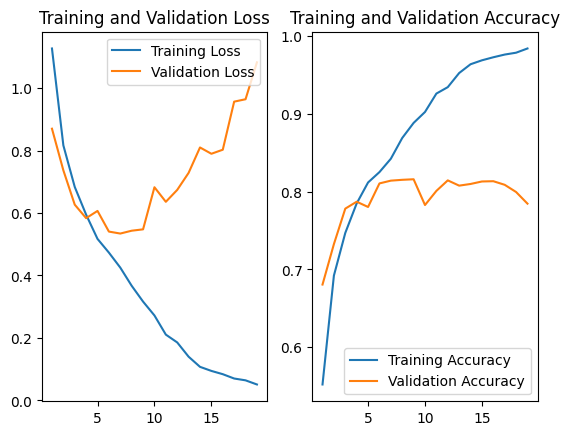


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.060076  0.980499
Test   1.071820  0.781333
---------------------------------------------------------

47/47 [==============================] - 2s 43ms/step


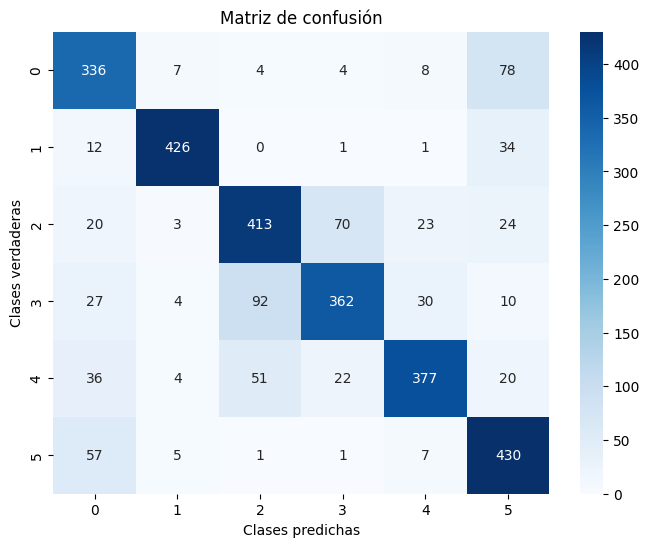


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       437
           1       0.95      0.90      0.92       474
           2       0.74      0.75      0.74       553
           3       0.79      0.69      0.74       525
           4       0.85      0.74      0.79       510
           5       0.72      0.86      0.78       501

    accuracy                           0.78      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.79      0.78      0.78      3000

Tiempo de ejecución: 263.33 segundos


In [23]:
# Empezamos calculando el tiempo de ejcución
start_time = time.time()

# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Conv2D(32, (3, 3), activation='relu')(i)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(output_labels, activation='softmax')(x)

    return tf.keras.Model(inputs=[i], outputs=[x])

# Modelo
model = build_model((img_height, img_width, 3), 6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

# Calculamos y mostramos el tiempo total de ejecución
end_time = time.time()
total_time_test3 = end_time - start_time
print(f'Tiempo de ejecución: {total_time_test3:.2f} segundos')

### 8.4. *Observaciones*

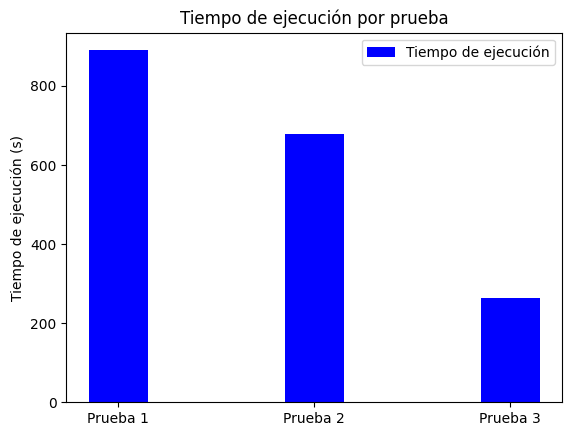

In [24]:
# Tiempo de ejecución de cada prueba
time_test1, time_test2, time_test3 = round(total_time_test1, 2), round(total_time_test2, 2), round(total_time_test3, 2)
tiempo = [time_test1, time_test2, time_test3]

# Etiquetas para las pruebas
labels = ['Prueba 1', 'Prueba 2', 'Prueba 3']

x = np.arange(len(labels))
width = 0.3

# Gráfico de barras
fig, ax = plt.subplots()

# Barras para el tiempo de ejecución
ax.bar(x, tiempo, width, label='Tiempo de ejecución', color='b')

# Etiquetas, título y leyenda
ax.set_ylabel('Tiempo de ejecución (s)')
ax.set_title('Tiempo de ejecución por prueba')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Continuando con nuestra metodología, llevamos a cabo tres pruebas utilizando diversos modelos con distintos niveles de complejidad.

La **Prueba 1** obtuvo las métricas más sobresalientes, mientras que la **Prueba 3** finalizó en el menor tiempo, aunque con un sobreajuste considerable. La **Prueba 2** tuvo una duración ligeramente menor que la **Prueba 1**, con métricas algo menos destacadas.

En este contexto, la **Prueba 1** se destaca como la mejor opción debido a su bajo nivel de sobreajuste y sus métricas altamente favorables, a pesar de su tiempo de ejecución.

## 9. **Modelos con bloques residuales identidad**

### 9.1. *Prueba 1*

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 random_flip_6 (RandomFlip)  (None, 64, 64, 3)            0         ['input_6[0][0]']             
                                                                                                  
 random_flip_7 (RandomFlip)  (None, 64, 64, 3)            0         ['random_flip_6[0][0]']       
                                                                                                  
 random_translation_2 (Rand  (None, 64, 64, 3)            0         ['random_flip_7[0][0]']       
 omTranslation)                                                                             

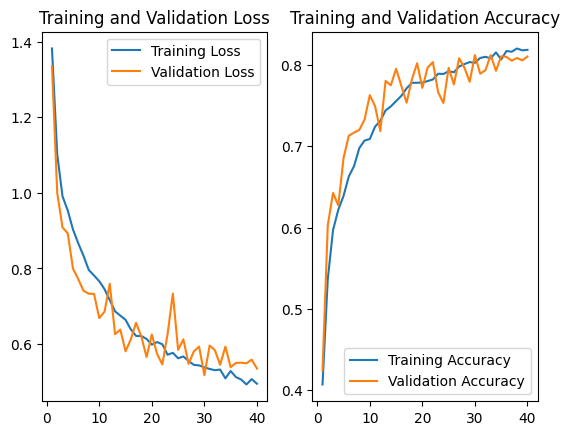


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.444211   0.84114
Test   0.533890   0.80900
---------------------------------------------------------

47/47 [==============================] - 2s 47ms/step


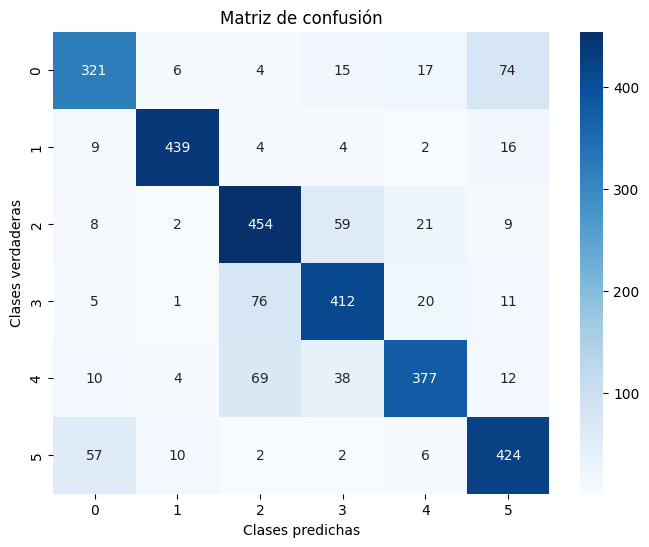


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.78      0.73      0.76       437
           1       0.95      0.93      0.94       474
           2       0.75      0.82      0.78       553
           3       0.78      0.78      0.78       525
           4       0.85      0.74      0.79       510
           5       0.78      0.85      0.81       501

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000

Tiempo de ejecución: 665.60 segundos


In [25]:
# Empezamos calculando el tiempo de ejcución
start_time = time.time()

def residual_block_identity(x, filters):
    shortcut = x

    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), padding='same')(shortcut)

    x = Add()([shortcut, x])

    output = Activation('relu')(x)
    return output

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = RandomFlip('horizontal')(inputs)
    x = RandomFlip('vertical')(x)
    x = RandomTranslation(0.1, 0.1, fill_mode='reflect')(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = residual_block_identity(x, 16)
    x = residual_block_identity(x, 16)
    x = residual_block_identity(x, 16)
    x = residual_block_identity(x, 16)

    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = residual_block_identity(x, 32)
    x = residual_block_identity(x, 32)
    x = residual_block_identity(x, 32)
    x = residual_block_identity(x, 32)

    x = Conv2D(32, (3, 3), activation='relu')(x)

    x = residual_block_identity(x, 64)
    x = residual_block_identity(x, 64)
    x = residual_block_identity(x, 64)
    x = residual_block_identity(x, 64)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Modelo
model = build_model((img_height, img_width, 3), 6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

# Calculamos y mostramos el tiempo total de ejecución
end_time = time.time()
total_time_test1 = end_time - start_time
print(f'Tiempo de ejecución: {total_time_test1:.2f} segundos')

### 9.2. *Prueba 2*

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 random_flip_6 (RandomFlip)  (None, 64, 64, 3)            0         ['input_6[0][0]']             
                                                                                                  
 random_flip_7 (RandomFlip)  (None, 64, 64, 3)            0         ['random_flip_6[0][0]']       
                                                                                                  
 random_translation_2 (Rand  (None, 64, 64, 3)            0         ['random_flip_7[0][0]']       
 omTranslation)                                                                             

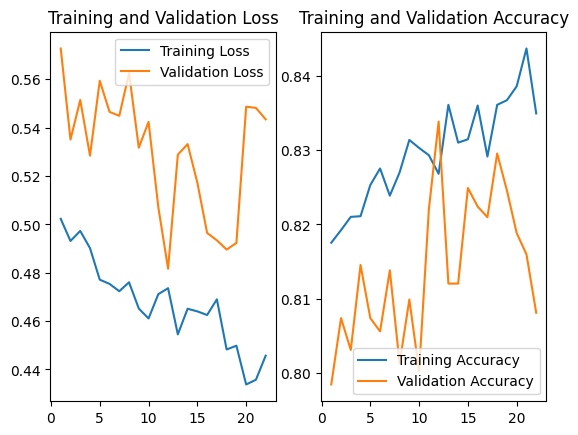


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.430964  0.840338
Test   0.529752  0.801333
---------------------------------------------------------

47/47 [==============================] - 2s 47ms/step


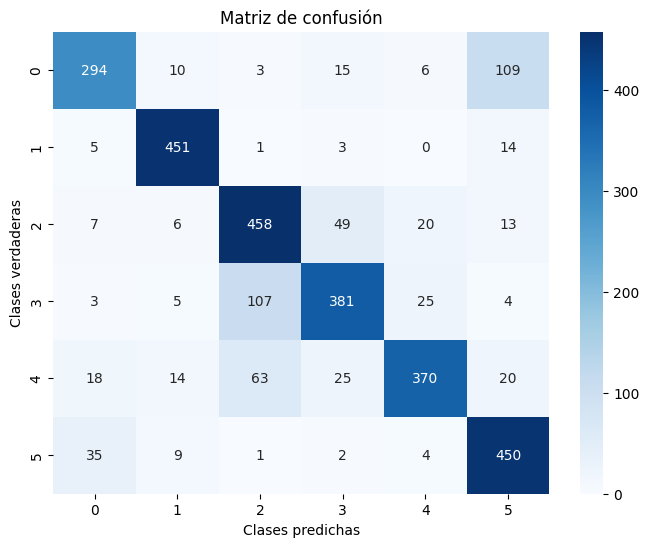


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.67      0.74       437
           1       0.91      0.95      0.93       474
           2       0.72      0.83      0.77       553
           3       0.80      0.73      0.76       525
           4       0.87      0.73      0.79       510
           5       0.74      0.90      0.81       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.81      0.80      0.80      3000

Tiempo de ejecución: 345.10 segundos


In [26]:
# Empezamos calculando el tiempo de ejcución
start_time = time.time()

def residual_block_identity(x, filters):
    x_skip = x

    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block_identity(x, 32)
    x = residual_block_identity(x, 32)
    x = residual_block_identity(x, 32)

    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block_identity(x, 64)
    x = residual_block_identity(x, 64)
    x = residual_block_identity(x, 64)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Modelo
model_residual_block = build_model(input_shape=(img_height, img_width, 3), num_classes=6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

# Calculamos y mostramos el tiempo total de ejecución
end_time = time.time()
total_time_test2 = end_time - start_time
print(f'Tiempo de ejecución: {total_time_test2:.2f} segundos')

### 9.3. *Observaciones*

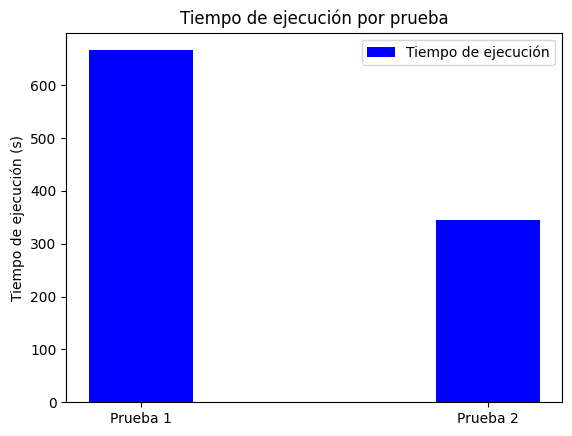

In [27]:
# Tiempo de ejecución de cada prueba
time_test1, time_test2 = round(total_time_test1, 2), round(total_time_test2, 2)
tiempo = [time_test1, time_test2]

# Etiquetas para las pruebas
labels = ['Prueba 1', 'Prueba 2']

x = np.arange(len(labels))
width = 0.3

# Gráfico de barras
fig, ax = plt.subplots()

# Barras para el tiempo de ejecución
ax.bar(x, tiempo, width, label='Tiempo de ejecución', color='b')

# Etiquetas, título y leyenda
ax.set_ylabel('Tiempo de ejecución (s)')
ax.set_title('Tiempo de ejecución por prueba')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

En esta situación, disponemos de dos pruebas únicamente. Ambas muestran prácticamente las mismas métricas de rendimiento, pero la **Prueba 2** exhibe un nivel de sobreajuste mucho mayor que la **Prueba 1**.

Por consiguiente, en este contexto, la elección más ventajosa sería optar por la **Prueba 1** debido a su menor sobreajuste y sus sólidas métricas, a pesar de su prolongado tiempo de ejecución.

## 10. **Modelo que usa como 'backbone' una arquitectura de TensorFlow**

### 10.1. *Cargamos nuevamente las imágenes sin reescalado*

In [4]:
# Definimos las rutas a los datasets
train_dir = 'TP1-3/seg_train/seg_train'
test_dir = 'TP1-3/seg_test/seg_test'

# Definimos el tamaño de lote y las dimensiones de las imágenes
batch_size = 64
img_height = 128
img_width = 128

# Utilizamos 'ImageDataGenerator' para cargar las imágenes sin reescalado.
# Esto es porque algunas arquitecturas de TensorFlow ya vienen con un método de escalado implementado
train_datagen = ImageDataGenerator(validation_split=0.2)
test_datagen = ImageDataGenerator()

# Cargamos las imágenes de entrenamiento, validación, prueba y predicción
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### 10.2. *EfficientNet*

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 dropout_7 (Dropout)         (None, 4, 4, 1280)        0         
                                                                 
 global_max_pooling2d_9 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_11 (Dense)            (None, 6)                 7686      
                                                           

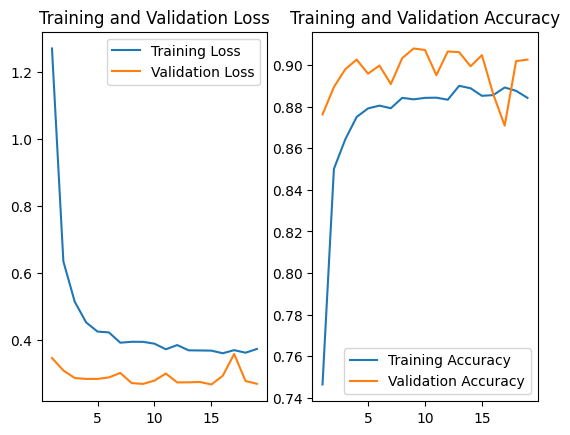


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.174604  0.936420
Test   0.270672  0.898333
---------------------------------------------------------

47/47 [==============================] - 3s 38ms/step


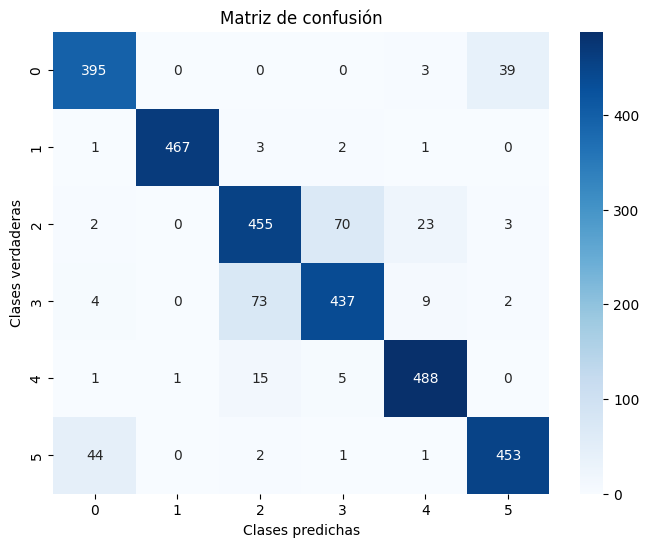


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       437
           1       1.00      0.99      0.99       474
           2       0.83      0.82      0.83       553
           3       0.85      0.83      0.84       525
           4       0.93      0.96      0.94       510
           5       0.91      0.90      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

Tiempo de ejecución: 191.15 segundos


In [14]:
# Empezamos calculando el tiempo de ejcución
start_time = time.time()

# Función para armar el modelo
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = Dropout(0.5)(x)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

# Creación
model = build_model((img_height, img_width, 3), 6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

# Calculamos y mostramos el tiempo total de ejecución
end_time = time.time()
total_time_test1 = end_time - start_time
print(f'Tiempo de ejecución: {total_time_test1:.2f} segundos')

### 10.3. *ResNet50*

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout_13 (Dropout)        (None, 4, 4, 2048)        0         
                                                                 
 global_max_pooling2d_13 (Gl  (None, 2048)             0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 256)               524544    
                                                          

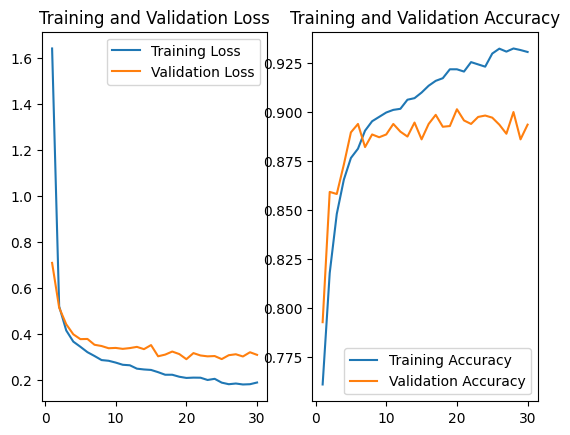


---------------------------------------------------------
Métricas Finales:
---------------------------------------------------------
           loss  accuracy
Train  0.146632  0.970347
Test   0.307031  0.891333
---------------------------------------------------------

47/47 [==============================] - 3s 48ms/step


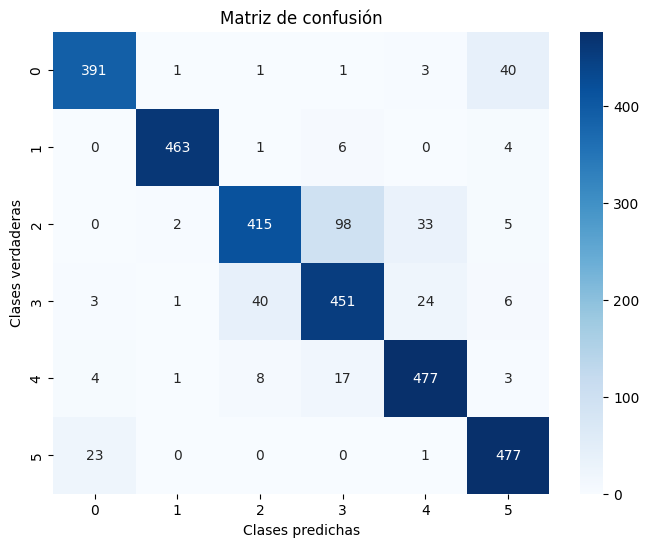


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       437
           1       0.99      0.98      0.98       474
           2       0.89      0.75      0.82       553
           3       0.79      0.86      0.82       525
           4       0.89      0.94      0.91       510
           5       0.89      0.95      0.92       501

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

Tiempo de ejecución: 388.08 segundos


In [18]:
# Empezamos calculando el tiempo de ejcución
start_time = time.time()

# Función para armar el modelo
def build_model(input_shape, num_classes):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = Dropout(0.5)(x)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(6, activation='softmax')(x)

    return tf.keras.Model(i, x)

# Creación
model = build_model((img_height, img_width, 3), 6)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=0, min_delta=1e-4, mode='min')

# Compilacion
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen
model.summary()

# Entrenamiento
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=200,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stopping],
)

# Métricas
evaluacion_test = model.evaluate(test_data, verbose=0, return_dict=True)
evaluacion_train = model.evaluate(train_data, verbose=0, return_dict=True)

loss = history.history['loss']
epoch = range(1, len(loss)+1, 1)
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure()

plt.subplot(1,2,1)
plt.plot(epoch, loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(epoch, accuracy, label='Training Accuracy')
plt.plot(epoch, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

metricas_finales = pd.DataFrame(columns=evaluacion_train.keys())
metricas_finales.loc['Train'] = evaluacion_train.values()
metricas_finales.loc['Test'] = evaluacion_test.values()

print('\n' + '-' * 57)
print('Métricas Finales:')
print('-' * 57)
print(metricas_finales)
print('-' * 57 + '\n')

# Predicciones
probabilidad_predicciones = model.predict(test_data)
predicciones = np.argmax(probabilidad_predicciones, axis=1)

# Matriz de confusión
matriz_confusion = confusion_matrix(test_data.classes, predicciones)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases predichas')
plt.ylabel('Clases verdaderas')
plt.title('Matriz de confusión')
plt.show()

# Reporte de clasificación
reporte_clasificacion = classification_report(test_data.classes, predicciones)

print('\nReporte de clasificación:')
print(reporte_clasificacion)

# Calculamos y mostramos el tiempo total de ejecución
end_time = time.time()
total_time_test2 = end_time - start_time
print(f'Tiempo de ejecución: {total_time_test2:.2f} segundos')

### 10.4. *Observaciones*

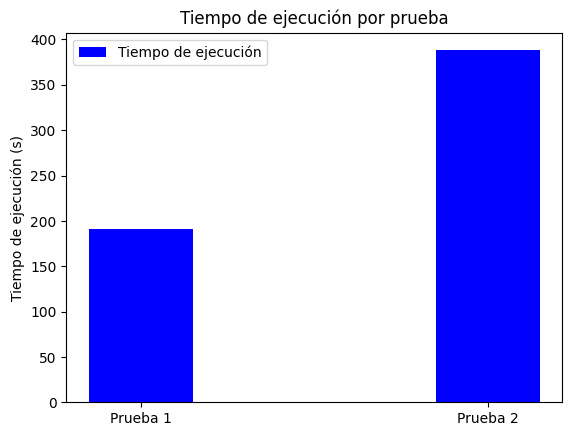

In [19]:
# Tiempo de ejecución de cada prueba
time_test1, time_test2 = round(total_time_test1, 2), round(total_time_test2, 2)
tiempo = [time_test1, time_test2]

# Etiquetas para las pruebas
labels = ['Prueba 1', 'Prueba 2']

x = np.arange(len(labels))
width = 0.3

# Gráfico de barras
fig, ax = plt.subplots()

# Barras para el tiempo de ejecución
ax.bar(x, tiempo, width, label='Tiempo de ejecución', color='b')

# Etiquetas, título y leyenda
ax.set_ylabel('Tiempo de ejecución (s)')
ax.set_title('Tiempo de ejecución por prueba')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

En este escenario, contamos con dos pruebas, una realizada con **EfficientNet** y otra con **ResNet50**. Ambas arrojaron resultados favorables, logrando superar a los *Modelos con Bloques Residuales Identidad* o a los *Modelos con Capas Densas y Convolucionales*. Aunque **ResNet50** tiene un overfitting mayor al de **EfficientNet**.

Un aspecto destacado es el tiempo de ejecución: **ResNet50** requirió considerablemente más tiempo que **EfficientNet**. De hecho, **EfficientNet** fue el modelo más rápido en obtener sus métricas, incluso en comparación con los modelos mencionados anteriormente.

Por lo tanto, para este problema de clasificación, la opción óptima sería utilizar **EfficientNet** por sus métricas, tiempo de ejecución y bajo overfitting.